# Deformable Attention

Welcome to the **Deformable Attention** workshop. In this workshop, we'll see how to
- Build a Deformable attention module, step by step
- See how its integrated in Deformable Attention Tranformer architecture
- Visualize the Attention results on sample images  

We'll first install and import certain modules that we need

In [1]:
!pip install torch==1.11.0+cpu torchvision==0.12.0+cpu --extra-index-url https://download.pytorch.org/whl/cpu
!pip install https://shi-labs.com/natten/wheels/cpu/torch1.11/natten-0.14.6%2Btorch1110cpu-cp310-cp310-linux_x86_64.whl
!pip3 install -q einops ipympl timm

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 39.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.0+cu121
    Uninstalling torchvision-0.18.0+cu121:
      Successfully uninstalled torchvision-0.18.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.0+cu121 requires torch==2.3.0, but you have torch 1.11.0+cpu which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 1.11.0+cpu which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
os.chdir("/content/drive/My Drive/thinkAutonomous/dl_blogs/Vision-Transformer-101")

Mounted at /content/drive


# Imports

In [3]:
import cv2
import torch
import einops
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_

# Constants

Input images are processed by Patch embedding module, before passed on to the Transformer blocks. Assuming a input RGB image of 224x224 size and `DAT tiny` architecture, the output of module is (1, 64, 56, 56)

We'll define some constants, related to attention module in first stage of Transformer block

In [4]:
bs = 1                # batch size
q_size = (56, 56)     # input feature map height, width
n_heads = 2           # number of attention heads
n_head_channels = 32  # channel per head
n_groups = 1          # depth wise convolution for efficiency
ksize = 9             # kernel size for offset
stride = 8

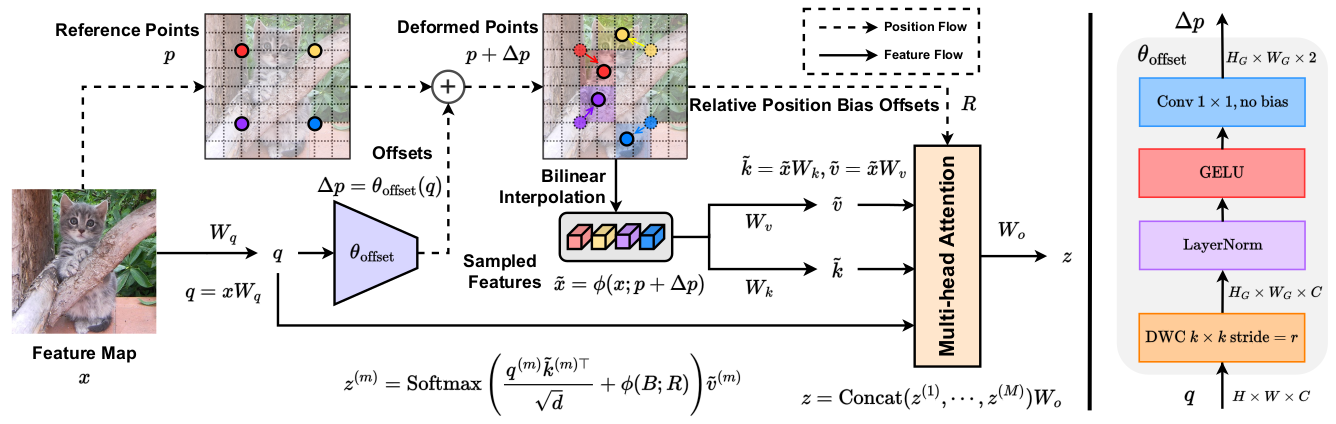

As you can see in above image, there are different components in Deformable Attention module such as:
- Reference grid generation
- Offset Generation network
- Calculating sampled features
- Attention mechanism
- Relative Position Embedding
- Applying Attention

We'll start with reference grid generation module

## Reference grid generation


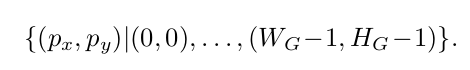

- Equally spaced 2D grid points are generated based on input feature map size. We'll make use of torch.meshgrid() function.
- Inputs
    - h_grid, w_grid, batch_size
    - n_groups
- Outputs
    - (1, batch_size, h_grid, w_grid) tensor, equally spaced points

In [5]:
def get_reference_points(h_grid, w_grid, bs, n_groups):
    ref_y, ref_x = torch.meshgrid(
        torch.linspace(0.5, h_grid - 0.5, h_grid),
        torch.linspace(0.5, w_grid - 0.5, w_grid),
        indexing='ij'
    )
    ref = torch.stack((ref_y, ref_x), -1)
    ref[..., 1].div_(w_grid - 1.0).mul_(2.0).sub_(1.0)
    ref[..., 0].div_(h_grid - 1.0).mul_(2.0).sub_(1.0)
    ref = ref[None, ...].expand(bs * n_groups, -1, -1, -1) # B * g H W 2
    ref = ref.clamp(-1.0, 1.0)
    return ref

In [6]:
ref_grid_pts = get_reference_points(h_grid=7,  w_grid=7, bs=1, n_groups=1)
print(ref_grid_pts.shape)
ref_grid_pts_np = ref_grid_pts.detach().cpu().numpy()

torch.Size([1, 7, 7, 2])


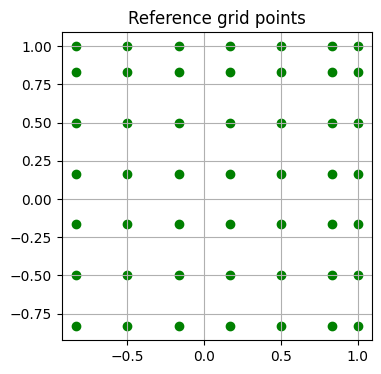

In [7]:
plt.figure(figsize=(4,4))
for row in range(7):
    for col in range(7):
        plt.scatter(ref_grid_pts_np[0, row, col, 0], ref_grid_pts_np[0, row, col, 1], c='g', marker = 'o')
plt.title('Reference grid points')
plt.grid(True)

## Offset prediction network

Before generating the offsets, we pass the input (patch embedding output) through a 1x1 conv block, which will be considered the query.

In [8]:
# patch embedding output
test_input_data = torch.Tensor(1, 64, 56, 56)

# total channels
nc = n_head_channels * n_heads
proj_q = nn.Conv2d(nc, nc, kernel_size=1, stride=1, padding=0)
q = proj_q(test_input_data)
print(f"Query shape = {q.shape}")

Query shape = torch.Size([1, 64, 56, 56])


This query is used as input to offset generation network

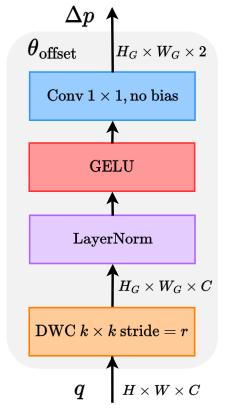

We'll first define a LayerNorm network, that accepts inputs of (bs, c, h, w) shape and outputs the same shaep, but applies a Layer Normalization inbetween.

In [9]:
class LayerNormModule(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        x = einops.rearrange(x, 'b c h w -> b h w c')
        x = self.norm(x)
        return einops.rearrange(x, 'b h w c -> b c h w')

The Conv modules, use Depth wise convolution for efficiency. This is specified using groups parameter in Pytorch. The groups are split b/w different heads. We'll define the renmaining layers as follows:

In [10]:
# stage 0, group channels
n_group_channels = 64

offset_generation_network = nn.Sequential(
            nn.Conv2d(n_group_channels, n_group_channels, kernel_size=ksize, stride=stride,
                      padding = ksize // 2, groups=n_group_channels), # 1, 64, 7, 7
            LayerNormModule(n_group_channels),
            nn.GELU(),
            nn.Conv2d(n_group_channels, 2, 1, 1, 0, bias=False)
        )

In [11]:
offset = offset_generation_network(q)
print(f"offset before reshape = {offset.shape}")

# outputs have channel size of 2, we can bring it to last dimension
offset = einops.rearrange(offset, 'b p h w -> b h w p')
print(f"offset after reshape = {offset.shape}")

offset before reshape = torch.Size([1, 2, 7, 7])
offset after reshape = torch.Size([1, 7, 7, 2])


Now that we have the reference points and the offsets. So, the final position is sum of ref grid points and the calculated offset.

In [12]:
pos = (offset + ref_grid_pts).clamp(-1., +1.)
print(pos.shape)

torch.Size([1, 7, 7, 2])


We have not trained the model yet, so the output of `pos` wont be useful. Just for illustration, we'll create random points and visualize the output

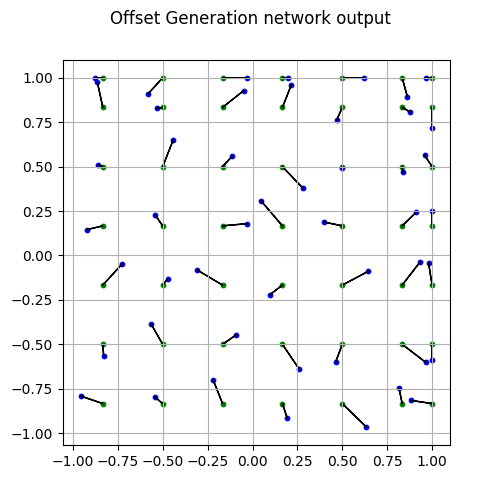

In [13]:
# generate random offsets, 0.16 = 9 / 56, where 9 is kernel size and 56 is feature map size
random_offsets = np.random.uniform(low=-0.16, high=0.16, size=(1, 7, 7, 2))
sample_pos_np = np.clip(ref_grid_pts_np + random_offsets, -1, 1)

%matplotlib ipympl
from google.colab import output
output.enable_custom_widget_manager()

plt.figure(figsize = (5,5))
plt.suptitle('Offset Generation network output')
plt.grid(True)

for row in range(7):
    for col in range(7):
        # add reference points and the deformed points
        s1 = plt.scatter(ref_grid_pts_np[0, row, col, 0], ref_grid_pts_np[0, row, col, 1], s= 10, c='g')
        s2 = plt.scatter(sample_pos_np[0, row, col, 0], sample_pos_np[0, row, col, 1], s= 10, c='b')

        # plot a line from reference point to deformed point
        dx = sample_pos_np[0, row, col, 0] - ref_grid_pts_np[0, row, col, 0]
        dy = sample_pos_np[0, row, col, 1] - ref_grid_pts_np[0, row, col, 1]
        plt.arrow(ref_grid_pts_np[0, row, col, 0], ref_grid_pts_np[0, row, col, 1], dx, dy)

## Calculating sampled features

Our input feature map is of size (56, 56), while we need only features from specific locations, as calculated by offset generation network. So, we need to sample features at (7,7) locations within input feature map.

Pytorch provides a [grid sampling](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html) function for the same

In [14]:
sampled_features = F.grid_sample(
    input=test_input_data, grid=pos[..., (1, 0)], # y, x -> x, y
    mode='bilinear', align_corners=True) # B * g, Cg, Hg, Wg

# flatten the height width dimension
sampled_features = einops.rearrange(sampled_features, 'g c h w -> g c 1 (h w)')
print(f"Sampled_features shape = {sampled_features.shape}")

Sampled_features shape = torch.Size([1, 64, 1, 49])


Our goal is to calculate the attention of each of input patch (56 x 56) w.r.t each of these sampled points (49). In the original vision transformer network, we had to calculate the attention for (56 x 56) to (56 x 56) elements.

## Attention mechanism

We have already computed the query, we need to calculate key. As earlier, we'll define 1x1 conv networks them. **NOTE** The Query operates on the full feature map, whereas the key and values operate on the sampled features

In [15]:
# we'll define some variables for convenience
n_sample = sampled_features.size()[-1]  # total number of keys
B, C, H, W = test_input_data.shape     # B =1, C = 64, H = 56, W = 56

proj_k = nn.Conv2d(nc, nc, kernel_size=1, stride=1, padding=0)
k = proj_k(sampled_features)
print(f"Key shape = {k.shape}")

Key shape = torch.Size([1, 64, 1, 49])


Attention mechanisms, involve usage of multiple heads. This forces each of head to learn independent features from each other. So, we have to reshape the query and keys before calculating attention

In [16]:
q = q.reshape(bs * n_heads, n_head_channels, H * W)
k = k.reshape(bs * n_heads, n_head_channels, n_sample)

print(f"Query shape = {q.shape}")
print(f"Key shape = {k.shape}")

Query shape = torch.Size([2, 32, 3136])
Key shape = torch.Size([2, 32, 49])


In [17]:
# calculate attention, attn = (q * k) / root(n_head_channels)
attn = torch.einsum('b c m, b c n -> b m n', q, k)

scale = n_head_channels ** -0.5
attn = attn.mul(scale)
print(f"Attention shape = {attn.shape}")

Attention shape = torch.Size([2, 3136, 49])


## Relative Position Embedding

- There's one more additional detail, before we can use attention values.
- We used all grid points in the original vision transformer attention module. - But, here, as we're using only selected points, we're introducing a bias. So, we need a way to differentiate the position of these features (deformed keys).
- So, we use a variant of Position embedding for doing so.
- Effectively, we need to calculate relative positions of the sampled features w.r.t input feature map

We'll first calculate as grid for the query, very similar to reference grid function

In [18]:
def get_query_grid(H, W, B):
    ref_y, ref_x = torch.meshgrid(
        torch.arange(0.0, H,),
        torch.arange(0.0, W),
        indexing='ij'
    )
    ref = torch.stack((ref_y, ref_x), -1)
    ref[..., 1].div_(W - 1.0).mul_(2.0).sub_(1.0)
    ref[..., 0].div_(H - 1.0).mul_(2.0).sub_(1.0)
    ref = ref[None, ...].expand(B * n_groups, -1, -1, -1) # B * g H W 2
    return ref

q_grid = get_query_grid(H, W, B)
print(f"Query grid shape = {q_grid.shape}")

Query grid shape = torch.Size([1, 56, 56, 2])


In [19]:
# q_grid = (1, 56, 56, 2) -> (1, 56 * 56, 2) -> (1, 3136, 1, 2)
# pos = (1, 7, 7, 2) -> (1, 7 * 7, 2) -> (1, 1, 49, 2)
displacement = (q_grid.reshape(B * n_groups, H * W, 2).unsqueeze(2) - pos.reshape(B * n_groups, n_sample, 2).unsqueeze(1)).mul(0.5)
print(f"Displacement grid shape = {displacement.shape}")

Displacement grid shape = torch.Size([1, 3136, 49, 2])


The displacement matrix contains relative position of each key w.r.t each patch

In [20]:
# create a position embedding in range [0, 111] as we're using centre of feature map as origin
rpe_table = nn.Parameter(torch.zeros(n_heads, q_size[0] * 2 - 1, q_size[1] * 2 - 1))
rpe_bias = rpe_table[None, ...].expand(B, -1, -1, -1)

attn_bias = F.grid_sample(
    input=rpe_bias,
    grid=displacement[..., (1, 0)],
    mode='bilinear', align_corners=True) # B * g, h_g, HW, Ns

attn_bias = attn_bias.reshape(B * n_heads, H * W, n_sample)
print(f"Attention bias shape = {attn_bias.shape}")

Attention bias shape = torch.Size([2, 3136, 49])


## Applying Attention

In [21]:
attn = attn + attn_bias
attn = F.softmax(attn, dim=2)
print(f"Attention shape = {attn.shape}")

Attention shape = torch.Size([2, 3136, 49])


In [22]:
# calculate values using 1x1 conv, account for multiple heads
proj_v = nn.Conv2d(nc, nc, kernel_size=1, stride=1, padding=0)
v = proj_v(sampled_features).reshape(B * n_heads, n_head_channels, n_sample)
print(f"Values shape = {v.shape}")

Values shape = torch.Size([2, 32, 49])


In [23]:
# output = attn * value
out = torch.einsum('b m n, b c n -> b c m', attn, v)
out = out.reshape(B, C, H, W)
print(f"DAT block output shape = {out.shape}")

DAT block output shape = torch.Size([1, 64, 56, 56])


## Putting it altogether

In [24]:
class DAttentionBaseline(nn.Module):
    def __init__(self, q_size, n_heads, n_head_channels, n_groups,
            attn_drop, proj_drop, stride, ksize):
        super().__init__()
        self.n_head_channels = n_head_channels
        self.scale = self.n_head_channels ** -0.5
        self.n_heads = n_heads
        self.q_h, self.q_w = q_size
        self.kv_h, self.kv_w = self.q_h // stride, self.q_w // stride
        self.nc = n_head_channels * n_heads
        self.n_groups = n_groups
        self.n_group_channels = self.nc // self.n_groups
        self.n_group_heads = self.n_heads // self.n_groups
        self.ksize = ksize
        self.stride = stride
        kk = self.ksize
        pad_size = kk // 2 if kk != stride else 0

        self.conv_offset = nn.Sequential(
            nn.Conv2d(self.n_group_channels, self.n_group_channels, kk, stride, pad_size, groups=self.n_group_channels),
            LayerNormModule(self.n_group_channels),
            nn.GELU(),
            nn.Conv2d(self.n_group_channels, 2, 1, 1, 0, bias=False)
        )

        self.proj_q = nn.Conv2d(self.nc, self.nc, kernel_size=1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(self.nc, self.nc, kernel_size=1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(self.nc, self.nc, kernel_size=1, stride=1, padding=0)
        self.proj_out = nn.Conv2d(self.nc, self.nc, kernel_size=1, stride=1, padding=0)
        self.proj_drop = nn.Dropout(proj_drop, inplace=True)
        self.attn_drop = nn.Dropout(attn_drop, inplace=True)
        self.rpe_table = nn.Parameter(torch.zeros(self.n_heads, self.q_h * 2 - 1, self.q_w * 2 - 1))
        trunc_normal_(self.rpe_table, std=0.01)

    @torch.no_grad()
    def _get_ref_points(self, H_key, W_key, B, dtype, device):
        ref_y, ref_x = torch.meshgrid(
            torch.linspace(0.5, H_key - 0.5, H_key, dtype=dtype, device=device),
            torch.linspace(0.5, W_key - 0.5, W_key, dtype=dtype, device=device),
            indexing='ij'
        )
        ref = torch.stack((ref_y, ref_x), -1)
        ref[..., 1].div_(W_key - 1.0).mul_(2.0).sub_(1.0)
        ref[..., 0].div_(H_key - 1.0).mul_(2.0).sub_(1.0)
        ref = ref[None, ...].expand(B * self.n_groups, -1, -1, -1) # B * g H W 2

        return ref

    @torch.no_grad()
    def _get_q_grid(self, H, W, B, dtype, device):
        ref_y, ref_x = torch.meshgrid(
            torch.arange(0, H, dtype=dtype, device=device),
            torch.arange(0, W, dtype=dtype, device=device),
            indexing='ij'
        )
        ref = torch.stack((ref_y, ref_x), -1)
        ref[..., 1].div_(W - 1.0).mul_(2.0).sub_(1.0)
        ref[..., 0].div_(H - 1.0).mul_(2.0).sub_(1.0)
        ref = ref[None, ...].expand(B * self.n_groups, -1, -1, -1) # B * g H W 2
        return ref


    def forward(self, x):
        B, C, H, W = x.size()
        dtype, device = x.dtype, x.device

        q = self.proj_q(x)
        q_off = einops.rearrange(q, 'b (g c) h w -> (b g) c h w', g=self.n_groups, c=self.n_group_channels)
        offset = self.conv_offset(q_off).contiguous()  # B * g 2 Hg Wg
        Hk, Wk = offset.size(2), offset.size(3)
        n_sample = Hk * Wk


        offset = einops.rearrange(offset, 'b p h w -> b h w p')
        reference = self._get_ref_points(Hk, Wk, B, dtype, device)
        pos = (offset + reference).clamp(-1., +1.)

        x_sampled = F.grid_sample(
                input=x.reshape(B * self.n_groups, self.n_group_channels, H, W),
                grid=pos[..., (1, 0)], # y, x -> x, y
                mode='bilinear', align_corners=True) # B * g, Cg, Hg, Wg
        x_sampled = x_sampled.reshape(B, C, 1, n_sample)

        q = q.reshape(B * self.n_heads, self.n_head_channels, H * W)
        k = self.proj_k(x_sampled).reshape(B * self.n_heads, self.n_head_channels, n_sample)
        v = self.proj_v(x_sampled).reshape(B * self.n_heads, self.n_head_channels, n_sample)

        attn = torch.einsum('b c m, b c n -> b m n', q, k) # B * h, HW, Ns
        attn = attn.mul(self.scale)

        rpe_table = self.rpe_table
        rpe_bias = rpe_table[None, ...].expand(B, -1, -1, -1)
        q_grid = self._get_q_grid(H, W, B, dtype, device)
        displacement = (q_grid.reshape(B * self.n_groups, H * W, 2).unsqueeze(2) - pos.reshape(B * self.n_groups, n_sample, 2).unsqueeze(1)).mul(0.5)
        attn_bias = F.grid_sample(
            input=einops.rearrange(rpe_bias, 'b (g c) h w -> (b g) c h w', c=self.n_group_heads, g=self.n_groups),
            grid=displacement[..., (1, 0)],
            mode='bilinear', align_corners=True) # B * g, h_g, HW, Ns

        attn_bias = attn_bias.reshape(B * self.n_heads, H * W, n_sample)
        attn = attn + attn_bias

        attn = F.softmax(attn, dim=2)
        attn = self.attn_drop(attn)

        out = torch.einsum('b m n, b c n -> b c m', attn, v)
        out = out.reshape(B, C, H, W)
        y = self.proj_drop(self.proj_out(out))
        return y, pos.reshape(B, self.n_groups, Hk, Wk, 2)


In [25]:
dat_module = DAttentionBaseline(q_size=(56, 56), n_heads=2, n_head_channels=32, n_groups=1, attn_drop=0,
                           proj_drop=0.0, stride=8, ksize=9)

# patch embedding output size = (1, 64, 56, 56)
# (bs, n_channels, feat_h, feat_w)
test_data = torch.Tensor(1, 64, 56, 56)
dat_module_output, deformed_points = dat_module(test_data)
print(dat_module_output.shape)
print(f"Deformed points = {[x.shape for x in deformed_points]}")

torch.Size([1, 64, 56, 56])
Deformed points = [torch.Size([1, 7, 7, 2])]


## Deformable Attention Transformer Architecture

The Deformable Attention module, described in earlier section, is used as building block in **DAT**(Deformable Attention Transformer), whose architecture is as follows:

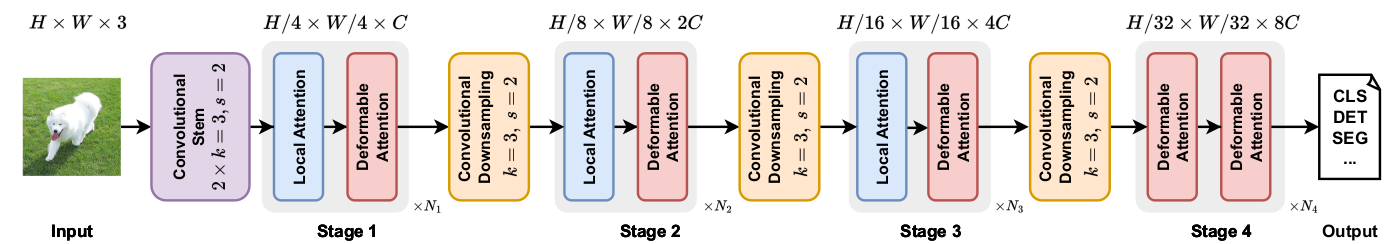

The complete model, uses another set of Local Attention (usually Neighbourhood attention) in Transformer blocks. For now, we'll consume the predefined model, and visualize the Deformable Attention output

In [26]:
from dat import DAT
model = DAT()
print(model)

DAT(
  (patch_proj): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LayerNormProxy(
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (2): GELU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LayerNormProxy(
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (stages): ModuleList(
    (0): TransformerStage(
      (proj): Identity()
      (ln_cnvnxt): ModuleDict()
      (layer_norms): ModuleList(
        (0): LayerNormProxy(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): LayerNormProxy(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): LayerNormProxy(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (3): LayerNormProxy(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
      )
      (mlps):

## Visualize Attention

We'll load a pretrained model, and visualized the output on sample images

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# change to evaluation mode and load pretrained model
model.eval();
model.to(device);
checkpoint = torch.load('fpn_dat_t_backbone.pth')
model.load_state_dict(checkpoint, strict=False)

_IncompatibleKeys(missing_keys=['cls_norm.norm.weight', 'cls_norm.norm.bias', 'cls_head.weight', 'cls_head.bias'], unexpected_keys=[])

Similar to Vision Transformer notebook, we'll define some helper functions and visualizer class to see output

In [28]:
from torchvision import transforms as pth_transforms
transform = pth_transforms.Compose([
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

def preprocess_image(image_path, reshape_size=(224, 224)):
    rgb_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    rgb_image = cv2.resize(rgb_image, reshape_size, interpolation=cv2.INTER_LINEAR)
    img = transform(rgb_image).unsqueeze(0)
    return rgb_image, img

rgb_image, img = preprocess_image('person.jpg')
print(f"rgb_image shape = {rgb_image.shape}, img shape = {img.shape}")

rgb_image shape = (224, 224, 3), img shape = torch.Size([1, 3, 224, 224])


In [29]:
# get output from model
_, deformed_points = model(img)
last_stage_attention = model.stages[-1].attns[-1].attn.cpu().detach().numpy()
print(f"Last stage attention shape = {last_stage_attention.shape}")
print(f"Deformed points shape = {[x.shape for x in deformed_points]}")

last_stage_deformed_points = deformed_points[-1][0]
last_stage_deformed_points = einops.rearrange(last_stage_deformed_points, 'ng h w p -> ng (h w) p')
print(f"Last stage Deformed points shape = {last_stage_deformed_points.shape}")

Last stage attention shape = (16, 49, 49)
Deformed points shape = [(1, 1, 7, 7, 2), (1, 2, 7, 7, 2), (1, 2, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 8, 7, 7, 2), (1, 8, 7, 7, 2)]
Last stage Deformed points shape = (8, 49, 2)


So, in last stage, we have an attention output of (16, 49, 49), where
- 16 = batch_size * num_heads
- 49 = 7 * 7 = H_feat * W_feat = number of patches
- 49 = num_keys = number of deformed points

Deformed points shape = (8, 49, 2) where
- 8 = num of groups
- 49 = keys = deformed points
- 2 = x,y position

**NOTE** The deformed values are in [-1, 1] range

As we did in vision transformer, we'll select a patch in the image, see what is trying to attend to

In [30]:
import random
import colorsys

def random_colors(N, bright=True):
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [31]:
import numpy as np
import matplotlib.patches as patches
import IPython.display as Disp
from ipywidgets import Button, Layout

class Visualize_Attention():
    def __init__(self, rgb_image, attention_map, keys, patch_size=32, figsize=(9,9), cmap='jet'):
        self.rgb_image = rgb_image
        self.attention_map = attention_map
        self.keys = keys
        self.ps = patch_size
        self.img_height, self.img_width, _ = self.rgb_image.shape
        self.colors = random_colors(attention_map.shape[0])

        self.fig = plt.figure(figsize=figsize)
        gs = self.fig.add_gridspec(nrows=6, ncols=6)
        plt.suptitle('DEFORMABLE ATTENTION KEYPOINTS')

        # RGB image with gridlines
        self.rgb_axes = self.fig.add_subplot(gs[0:5, 1:5])
        self.rgb_axes.imshow(self.rgb_image)
        self.rgb_axes.set(xticks=[], yticks=[])
        for x in range(0, self.img_width, self.ps):
            self.rgb_axes.axvline(x, color='gray', linestyle='-', linewidth = 0.5)
        for y in range(0, self.img_height, self.ps):
            self.rgb_axes.axhline(y, color='gray', linestyle='-', linewidth = 0.5)
        self.rect = None

        # attention maps subplot
        self.attn_head_axes = []
        for row in range(6):
            if row == 5:
                cols = np.arange(6).tolist()
            else:
                cols = [0,5]
            for col in cols:
                head_axes = self.fig.add_subplot(gs[row, col])
                im = head_axes.imshow(np.zeros((self.img_height, self.img_width)))
                head_axes.set(xticks=[], yticks=[])
                self.attn_head_axes.append(head_axes)
        self.fig.tight_layout()

        # triggers
        self.trigger = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        visualize_button = Button(description = "Visualize Attention Heads")
        Disp.display(visualize_button)
        visualize_button.on_click(self.plot_patch_attention)

    def onclick(self, event):
        if event.inaxes == self.rgb_axes:
            self.patch_x = int(event.xdata // self.ps)
            self.patch_y = int(event.ydata // self.ps)
            if(self.rect is not None):
                self.rect.remove()
            self.rect = patches.Rectangle((self.patch_x * self.ps, self.patch_y * self.ps),
                                      self.ps, self.ps, linewidth=4, ec='r', fc='none')
            self.rgb_axes.add_patch(self.rect)


    def plot_patch_attention(self, _):
        # plot attention maps of all heads of corresponding patch
        reshaped_image = cv2.resize(self.rgb_image, (112, 112), cv2.INTER_LINEAR)
        for hi, ax in enumerate(self.attn_head_axes):
            # hi_patch_attn_scores = (49,) vector for the patch
            hi_patch_attn_scores = last_stage_attention[hi, self.patch_x * 7 + self.patch_y]

            # select the top 5 keys, based on attention score
            top_keypts_indices = np.argsort(hi_patch_attn_scores)[::-1][:5]
            top_keypts = self.keys[:, top_keypts_indices, :]

            # convert from [-1,1] to pixel coordinates [112, 112], shape = (8, 5, 2)
            top_keypts = np.clip((top_keypts + 1) * 56, 0, 112)
            top_keypts = top_keypts.reshape(-1,2)

            # plot top keypoints w.r.t head
            ax.clear()
            im = ax.imshow(reshaped_image)
            ax.set(xticks=[], yticks=[])
            ax.set_title(f"Head_{hi}", size=6)
            ax.scatter(top_keypts[:,0], top_keypts[:,1], c = self.colors[hi], s= 1)

            # draw lines from center of patch to each keypt
            p_center_x = int((self.patch_x + 0.5) * 16)
            p_center_y = int((self.patch_y + 0.5) * 16)
            for i in range(len(top_keypts)):
                ax.plot([p_center_x, top_keypts[i,0]], [p_center_y, top_keypts[i,1]], c = self.colors[hi], lw=0.5)
            self.fig.subplots_adjust(hspace=0.05)

Button(description='Visualize Attention Heads', style=ButtonStyle())

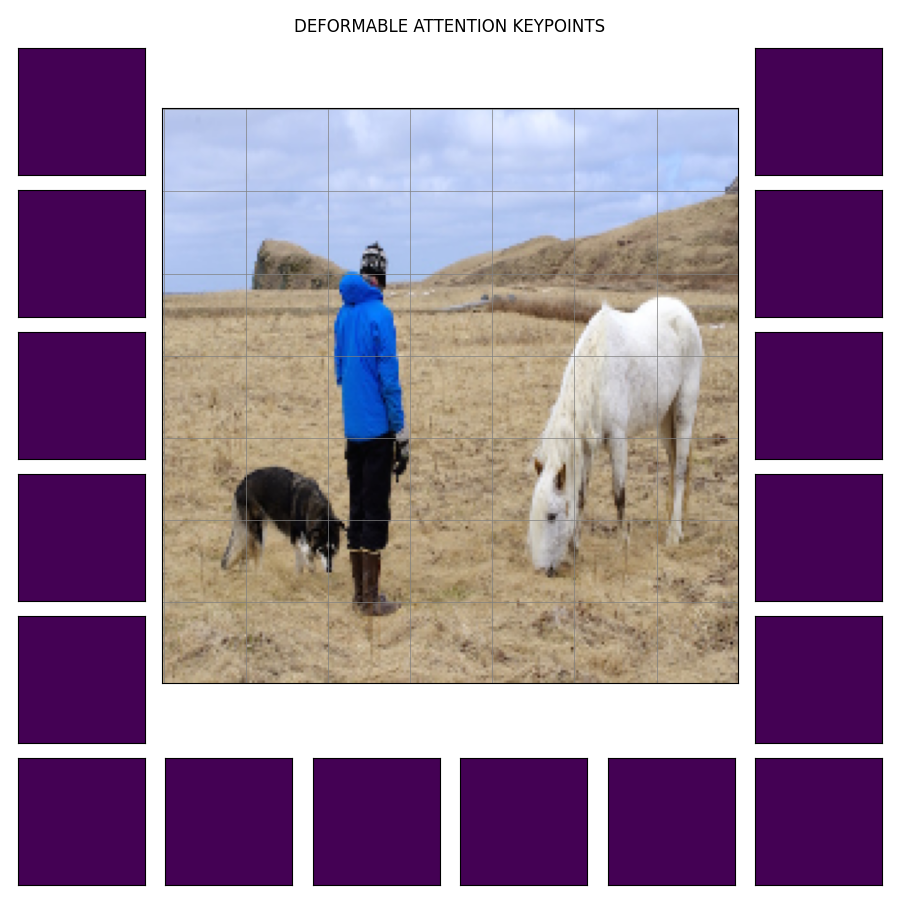

<ipython-input-31-0e3c725df0b8>:80: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(top_keypts[:,0], top_keypts[:,1], c = self.colors[hi], s= 1)


In [32]:
%matplotlib ipympl
from google.colab import output
output.enable_custom_widget_manager()
visualizer = Visualize_Attention(rgb_image, last_stage_attention, last_stage_deformed_points)

## References
- [DAT++: Spatially Dynamic Vision Transformer with Deformable Attention](https://arxiv.org/pdf/2309.01430)